In [1]:
import sys, os, json, copy, sklearn, shap, gc, joblib, copy, time
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMClassifier
import pickle as pkl
from tqdm import tqdm
from smart_open import open
import seaborn as sns
from sklearn.metrics import roc_curve,roc_auc_score, precision_score, recall_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from rdsutils.woe import WOE_Transform                                             
from rdsutils.metrics import get_pred_reports

pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', None)

sys.path.insert(1, "./")
import utility.performance_eval_v3 as p_eval
from utility  import data_summary, woe, data_eda, psi
from utility.governance import get_risk_plot,get_feature_by_importance, get_pdp, get_shap_dependence, pickle_obj,\
     plot_hist, get_woe_plots, save_pdp
from utility.plot_feature import display_feature_importance, save_shap_dependence, plot_lgbm_splits

from utility import model_trainer
from utility.preprocess import Preprocess
from utility.feature_selection import get_monotone_dir,compute_shap,get_feature_shap_abs,remove_features

%load_ext autoreload
%autoreload 2

print(lgb.__version__)

3.2.1


### read data

In [2]:
config_path = "s3://sofi-data-science/hpeng/pl-gen4/artifact/config.json"
artifact_path = "s3://sofi-data-science/hpeng/pl-gen4/artifact"
with open(os.path.join(config_path), "r") as f:
    config = json.load(f)

In [3]:
exp_dict = pd.read_csv(config["meta"]["exp_dict_path"])
af_dict = pd.read_csv(config["meta"]["af_member_cust_dict_path"])

In [4]:
segment='prescreen'
lgbm_31_hp = pkl.load(open('artifact/'+segment+'_final_model.pkl', 'rb'))

final_features = ['p13_upl8132', 'p13_bcc8322', 'p13_bcc5520',
    't11_tall3205', 'p13_upl0438', 'p13_all7312', 
    'p13_all7518', 'p13_rta7300', 'p13_iqz9420', 
    'p13_iqf9540', 'p13_iqt9510', 'p13_iqz9425', 't11_trev0722', 
    't11_tstu2752', 't11_tiln2755', 't11_tmti2752',  
    't11_tiln2754', 'p13_all7936', 'p13_all8352', 'p13_cru1300',
    'p13_reh7120', 't11_tbca2526', 't11_tbca3530', 
    't11_tbca4504', 't11_tbca2381', 't11_tbcc3305',
    't11_tbcc1303', 'p13_upl8320', 'p13_aut8140',
    'p13_cru8320', 'p13_rtr5520',
]

In [5]:
# target
target = 'target_v2'
target_indeterminate = 'indeterminate_v2'
weight = 'weight'
weight_eval = 'weight_eval'

In [6]:
feature_list = final_features + config["data_columns"]["weights"] + config["data_columns"]["target_cols"] \
            + config["data_columns"]["benchmark_cols"] +config["data_columns"]["meta_cols"] + ['all_time_lending_member_flag']
feature_list = pd.unique(feature_list).tolist()

In [7]:
df_dev1_full = pd.read_parquet(config["data"]["clean"]["all_features_dev1"], columns = feature_list)
df_dev2_full = pd.read_parquet(config["data"]["clean"]["all_features_dev2"], columns = feature_list)
df_dev_full = pd.concat([df_dev1_full, df_dev2_full], axis=0, ignore_index=True)

### data preprecessing
- assign weight
- encode special value/missing based on WOE

In [8]:
col = "ri_source"
weights = {"booked": 1,
           "proxy": 1,
           "others": 0.25}

pp = Preprocess(exp_dict)

df_dev_full["weight_eval"] = df_dev_full["weight_cob"] * df_dev_full["weight_ri_v2"]
%time df_dev_full_ = pp.transform(df_dev_full, final_features, weights, drop_indeterminate=target_indeterminate, existing_weights_col="weight_eval")

100%|██████████| 31/31 [00:11<00:00,  2.72it/s]



        added columns:
            weight: training sample_weight scaled using provided weights by ri_source
                weight_eval * weight_sample
        
dropping indeterminate col: indeterminate_v2
CPU times: user 8.73 s, sys: 5.78 s, total: 14.5 s
Wall time: 14.4 s


In [9]:
imputer_path = 's3://sofi-data-science/jxu/pl-gen4/prescreen/prescreen_final/prescreen_impute_values.json'
with open(os.path.join(imputer_path), "r") as f:
    impute_vals = json.load(f)

In [10]:
for f in tqdm(final_features):
    try:
        val = impute_vals[f]
        df_dev_full_[f].fillna(val, inplace=True)
    except:
        print("no special/missing value for " + f)

 65%|██████▍   | 20/31 [00:00<00:00, 82.65it/s]

no special/missing value for p13_iqz9420
no special/missing value for p13_iqz9425


100%|██████████| 31/31 [00:00<00:00, 78.41it/s]


### fit model with tuned parameters

In [11]:
params = {'boosting_type': 'gbdt',
                 'class_weight': None,
                 'colsample_bytree': 1.0,
                 'importance_type': 'split',
                 'learning_rate': 0.007,
                 'max_depth': 8,
                 'min_child_samples': 20,
                 'min_child_weight': 0.001,
                 'min_split_gain': 0.0,
                 'n_estimators': 2500,
                 'n_jobs': -1,
                 'num_leaves': 45,
                 'objective': 'binary',
                 'reg_alpha': 0.0,
                 'reg_lambda': 0.0,
                 'silent': True,
                 'subsample': 1.0,
                 'subsample_for_bin': 200000,
                 'subsample_freq': 0,
                 'metric': 'auc',
                 'verbosity': -1,
                 'early_stopping_rounds': None,
                 'feature_pre_filter': False,
                 'lambda_l1': 3.9,
                 'lambda_l2': 8.4,
                 'feature_fraction': 0.9,
                 'bagging_fraction': 0.9,
                 'min_data_in_leaf': 700,
                 'monotone_constraints': [-1,
                  -1,
                  -1,
                  -1,
                  1,
                  -1,
                  1,
                  1,
                  1,
                  -1,
                  -1,
                  1,
                  1,
                  -1,
                  -1,
                  -1,
                  -1,
                  -1,
                  -1,
                  -1,
                  1,
                  -1,
                  -1,
                  -1,
                  1,
                  -1,
                  1,
                  -1,
                  1,
                  -1,
                  -1],
                 'random_state': 12345,
                 'deterministic':True}

lgbm_best = LGBMClassifier(**params)

In [12]:
model_final = model_trainer.lgbm_model_trainer(df_dev_full_, target, final_features, lgbm_best,
                       weight=weight, indeterminate = target_indeterminate)

data statistics (4369879, 50)
indeterminate removed! column name:  indeterminate_v2
data statistics after removing indeterminate (4369879, 50)
indetermineate:  0.0
[LightGBM] [Warning] lambda_l1 is set=3.9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.4
training elapse:,  2.036489951610565  mins


###  replicate model performance on development data

In [13]:
df_dev_full_['pre_lgbm_31_hp'] = lgbm_31_hp.predict_proba(df_dev_full_[lgbm_31_hp.feature_name_])[:,1]
df_dev_full_['pre_model_replicate'] = model_final.predict_proba(df_dev_full_[model_final.feature_name_])[:,1]

In [14]:
pred_cols = ['pre_lgbm_31_hp',
             'pre_model_replicate']

test_df_ = df_dev_full_.copy()
print(f"--------TTD --------")
perf = get_pred_reports(test_df_, 'target_v2', pred_cols, 
                            sample_weight_col="weight_eval").sort_values("ks")
display(perf.round(4))

test_df_ = df_dev_full_[(df_dev_full_.ri_source=='booked')].copy()

print(f"--------booked --------")
perf = get_pred_reports(test_df_, 'target_v2', pred_cols, 
                            sample_weight_col="weight_eval").sort_values("ks")
display(perf.round(4))

--------TTD --------


,auc,ap,ks
pre_lgbm_31_hp,0.7599,0.3786,38.41
pre_model_replicate,0.7599,0.3786,38.41


--------booked --------


,auc,ap,ks
pre_lgbm_31_hp,0.7328,0.1598,34.07
pre_model_replicate,0.7328,0.1598,34.07


### feature analysis

(<Figure size 648x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Feature Importance (avg over folds)'}, xlabel='importance', ylabel='feature'>)

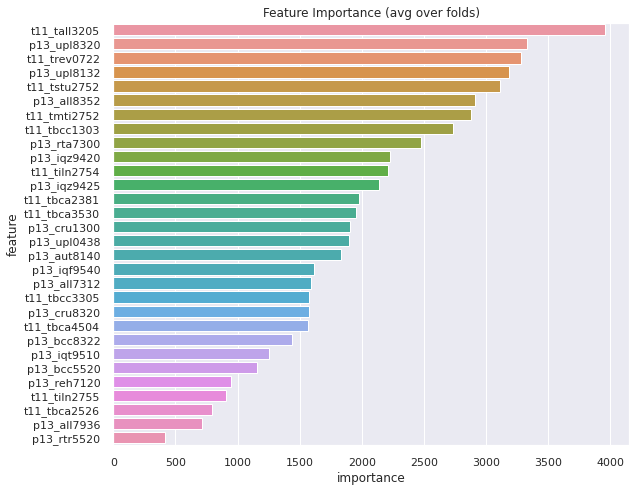

In [16]:
import rdsutils.plot as rdsplot
rdsplot.display_feature_importance(model_final.feature_name_, 
                                   model_final.feature_importances_,max_n_features=-1)

In [17]:
df_dev_full_['pred'] = model_final.predict_proba(df_dev_full_[model_final.feature_name_])[:,1]
feature_by_imp = get_feature_by_importance(model_final)

In [18]:
shap_values = compute_shap(model_final, df_dev_full_[model_final.feature_name_])
features = get_feature_shap_abs(shap_values[0], model_final.feature_name_, weight_series=df_dev_full_[weight])

In [19]:
shap_ = features.rename("shap").to_frame()
ft_by_shap = shap_.sort_values("shap", ascending=False).index.to_list()

Text(0.5, 1.0, 'LGBM Shap Value')

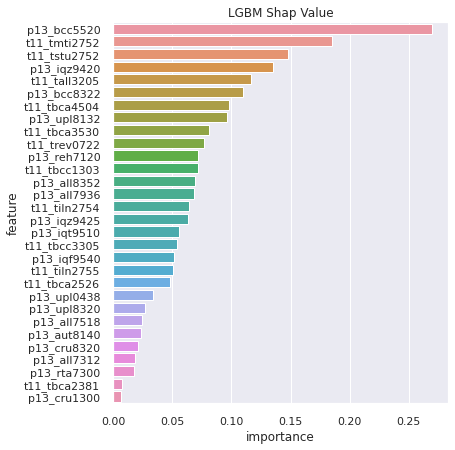

In [20]:
fig, axs = plt.subplots(ncols=1, figsize=(6, 7))
display_feature_importance(shap_.index,
                           shap_.shap,
                           max_n_features=-1,
                           ax=axs,
                           title="LGBM Shap Value")
axs.set_title("LGBM Shap Value")

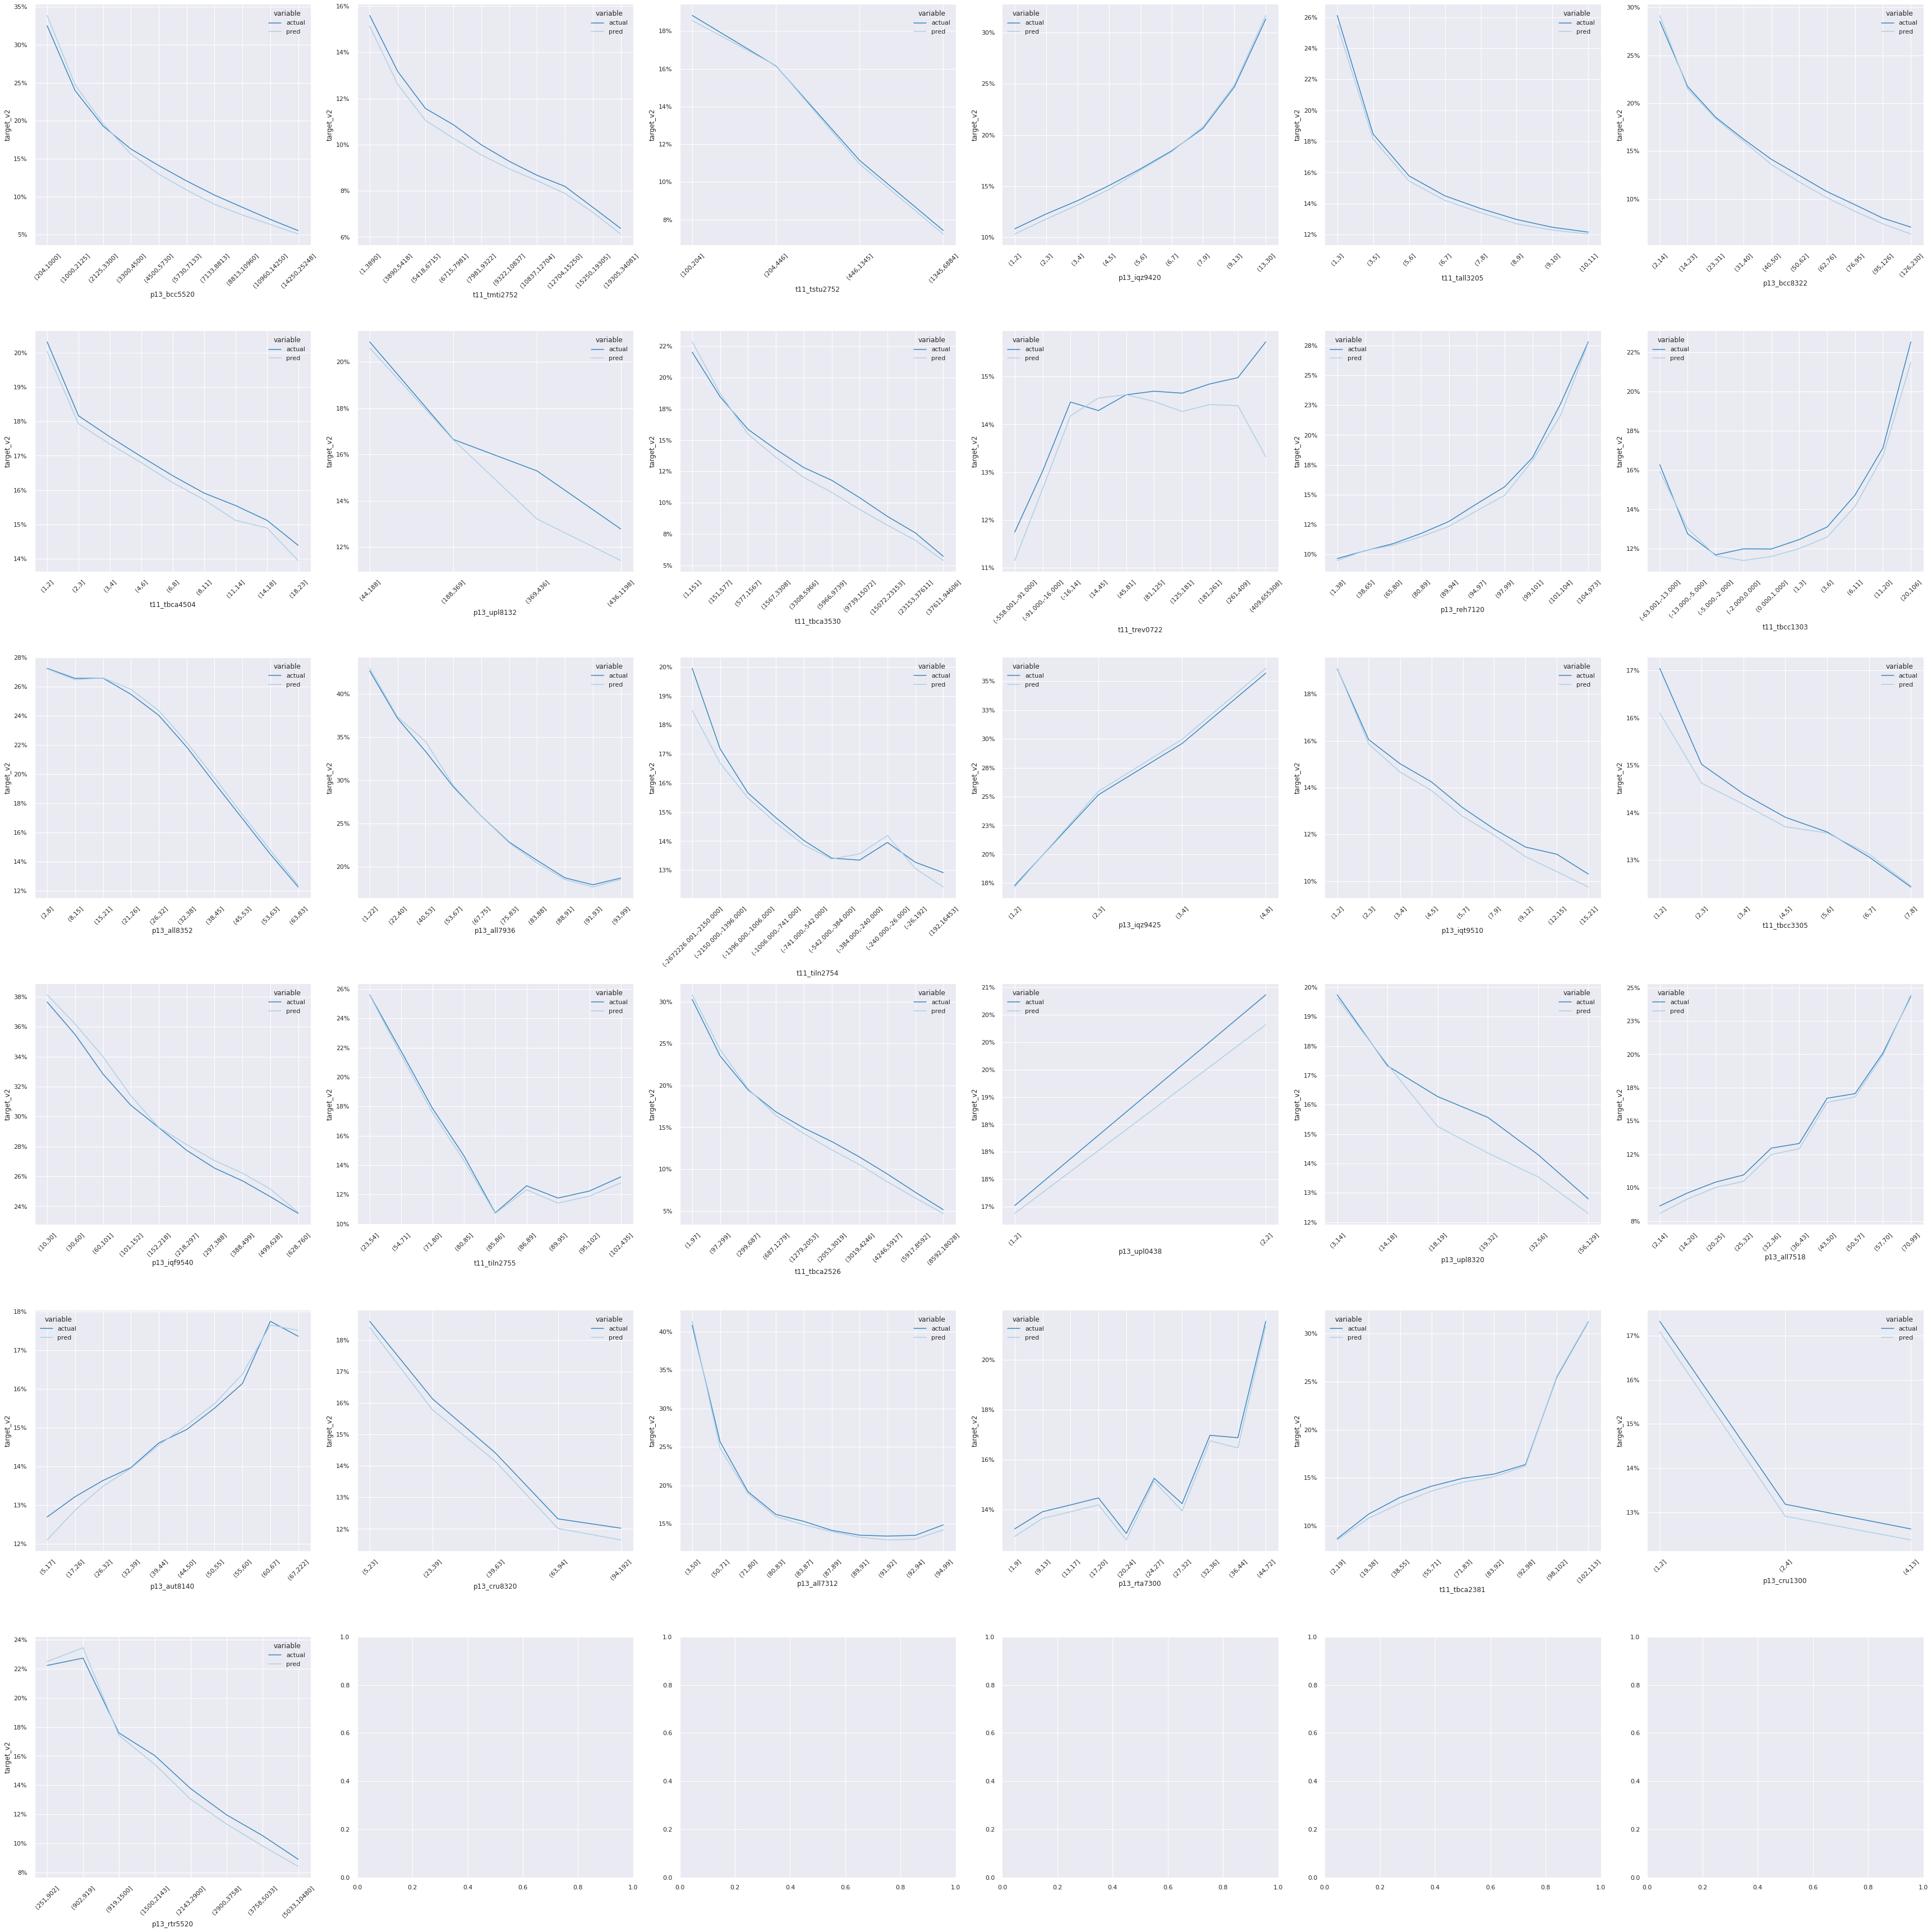

In [21]:
dir_path = './artifact/'+segment 
fig,axis = get_risk_plot(df_dev_full_,target, 'pred', ft_by_shap,equal_width=False, weight = weight_eval)
fig.savefig(os.path.join(dir_path, "risk_sensitivity.png"))

31it [01:25,  2.77s/it]


CPU times: user 1h 24min 28s, sys: 913 ms, total: 1h 24min 28s
Wall time: 1min 28s


CPU times: user 18min 57s, sys: 264 ms, total: 18min 57s
Wall time: 25.1 s


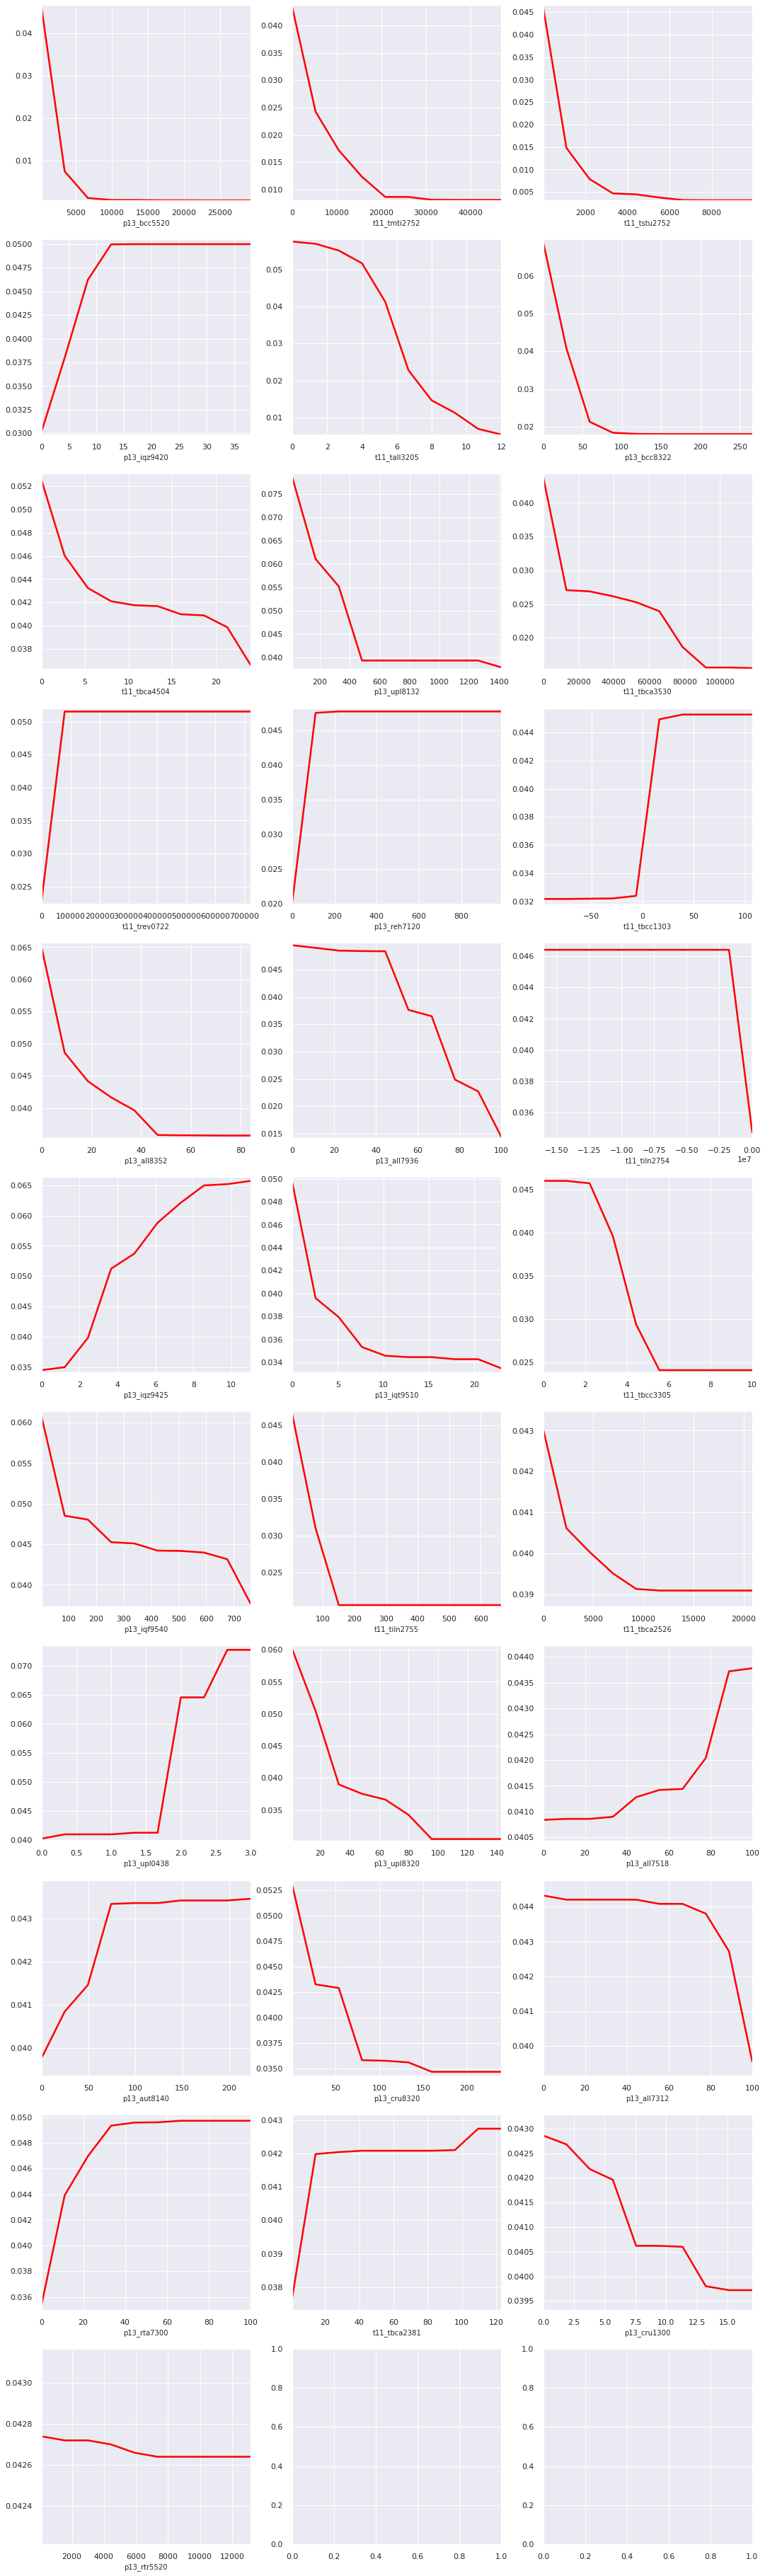

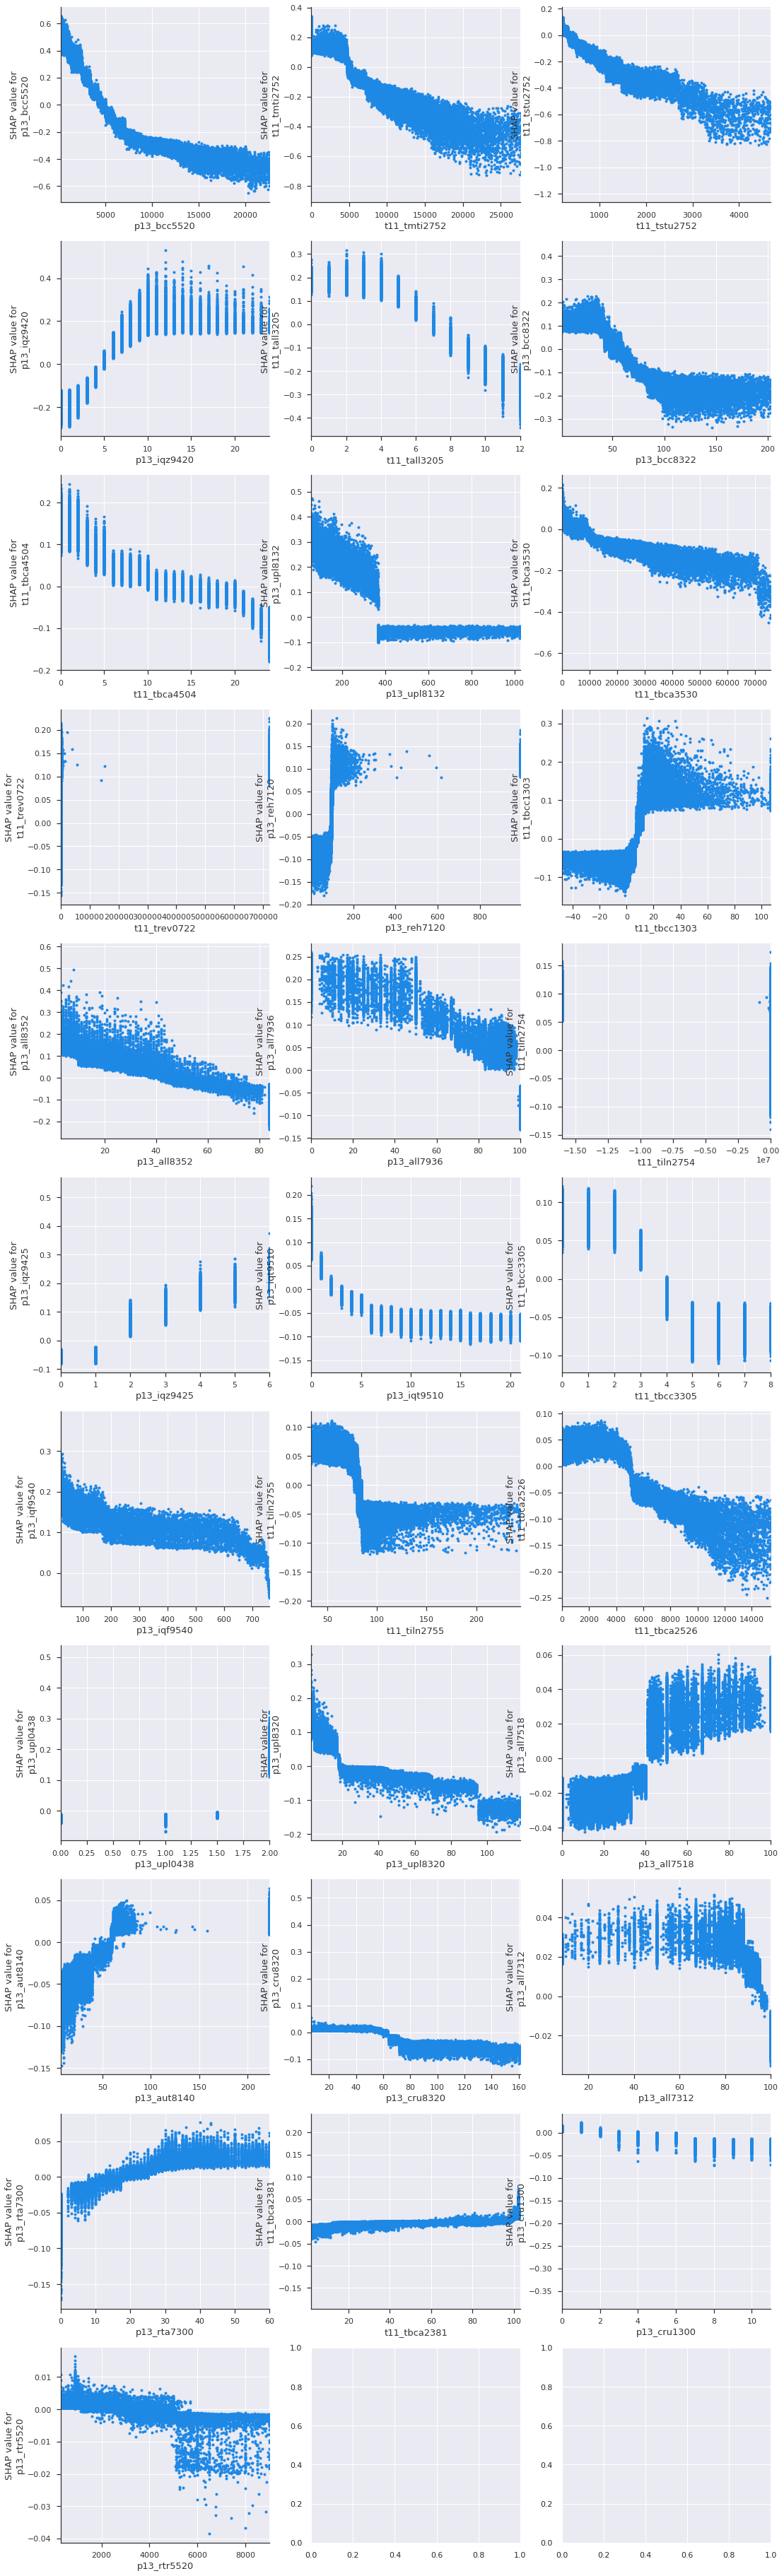

In [22]:
df_ = df_dev_full_[(df_dev_full_.ri_source!='others') | (df_dev_full_[target]==0)].sample(n=50000, random_state=12345)
%time save_pdp(model_final, df_,final_features , ft_by_shap, dir_path , suffix="")
%time save_shap_dependence(model_final, df_, ft_by_shap, dir_path, suffix="")

#### save model and attributes

In [23]:
# pkl.dump(model_final, open('artifact/'+segment+'_final_model.pkl', 'wb'))
# pkl.dump(impute_vals, open('artifact/'+segment+'_final_imputed_val.pkl', 'wb'))
# model_final.booster_.save_model('artifact/'+segment+'_final_model.txt')

In [24]:
# pkl.dump(model_final, open('../../../models/final/'+segment+'_final.pkl', 'wb'))
# pkl.dump(impute_vals, open('../../../models/final/'+segment+'_final_imputed_val.pkl', 'wb'))
# model_final.booster_.save_model('../../../models/final/'+segment+'_final.txt')

In [25]:
def get_feature_descriptions(features, data_dict, lgbm):
    dd_cols = ["field_name", "long description", "tag","min","max","categorical"]
    dd = data_dict[dd_cols]
    dd = dd[dd.field_name.isin(lgbm.feature_name_)]
    dd.set_index("field_name", inplace=True)
    
    dd_fields = set(data_dict.field_name.unique())
    bureau_fts = [f for f in features if f in dd_fields]
    bureau_dd = dd.loc[bureau_fts]
    
    if len(lgbm.feature_name_) == len(bureau_fts):
        return bureau_dd
    
    custom_ft = [f for f in features if f not in dd_fields]
    custom_dd = pd.DataFrame(index=custom_ft)
    return pd.concat([bureau_dd, custom_dd]).loc[features]

combined_dict_update = pd.read_csv(f's3://sofi-data-science/hpeng/pl-gen4/data_dump/data_dict/combined_dict.csv')

In [26]:
feature_dict= get_feature_descriptions(ft_by_shap, combined_dict_update, model_final)
dir_map = dict(zip(model_final.feature_name_, model_final.get_params()["monotone_constraints"]))
feature_dict["dir"] = [dir_map[k] for k in feature_by_imp]
feature_dict["rank"] = range(1, len(feature_by_imp)+1)

feature_dict.to_csv("./artifact/"+segment + "-" +'final_feature.csv')